In [ ]:
!pip install qiskit==0.7.1
!pip install qiskit_aer==0.1.1
!pip install IBMQuantumExperience

# Implementation of Quantum Walks on graph  for IBM Q
This notebook is based on the paper of  B L Douglas and J B Wang, "Efficient quantum circuit implementation of quantum walks", arXiv:0706.0304 [quant-ph].

## Contributors
Jordan Kemp(University of Chicago), Shin Nishio(Keio University), Ryosuke Satoh(Keio University), Desiree Vogt-Lee(University of Queensland), and Tanisha Bassan(The  Knowledge Society)

## Introduction: challenges in implementing quantum walk

There are so  many types of quantum walks. Walker can walk on n-dimensional space or any limited graphs. First we talk about the concept and dynamics of Quantum and Classical random walk. After that we show the implementation of Quantum Walk on cycle graph.

## Random walk 
Random walk is a dynamics which is randomly time evolving system. Figure shows a simple type of random walk. 

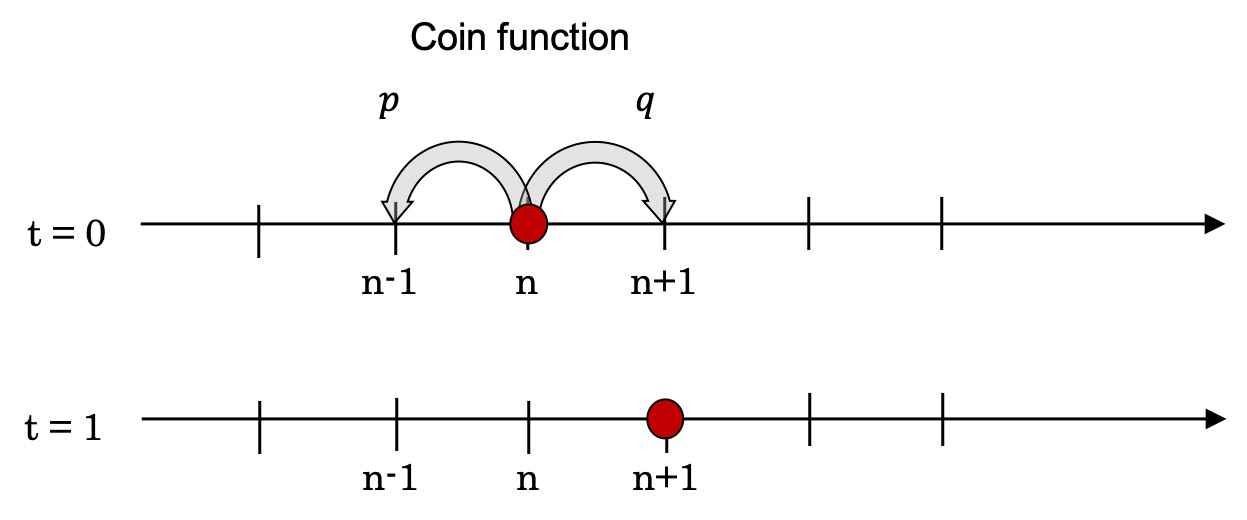

In [10]:
import os
import os.path
from IPython.display import display
from PIL import Image
path = "./random_walk.jpg"
display(Image.open(path))

The dynamics can be regarded as a simple algorithm as shown.
1. There is a $n$-dimension(in this case, one for simple) space and a walker start at the point $x=0$
2. take a step either forward (toward $+x$) or backward(toward $-x$) 
in 2., the choice is to be made randomly(ex: coin-flip). We call this "Coin Operator". 

In this system, $p+q = 1$

## Quantum walk 
Quantum walk is "quantum version" of random walk. This means theoin function can be Unitary gate($U(2)$) which is non-random and reversible. 

$p+q = U ∈ U(2)$. 

In this experiments, we use Hadamard gate for coin function since it puts our qubits in a state of superposition simulating the coin based probability, 
$$H=\frac{1}{\sqrt{2}}\left [{\begin{array}{rr}1 & 1 \\ 1 & -1\\ \end{array}}\right]$$

There are continuous and discrete quantum walks, in our experiment we use the discrete framework. In the discrete, unitary operations are made of coin and shift operators U = SC which work in a state space.
An arbitrary undirected graph $G(V,E)$ where $V = {v_1, v_2, ..v_n}$ as nodes on the graph and $E = {(v_x, v_y) , ( v_i, v_j) …}$ as edges that combine different nodes together.
The quantum walk extends into a position space where each node vi with a certain valency di is split into di subnodes. The shifting operator then acts as $S (v_i, a_i) = (v_j, a_j)$ and coin operator are unitary gates which combine the probability amplitudes with individual subnodes under each node.
A unitary of $v_i$ with valency $d_i$ can be represented as $(d_i \times d_i)$. The total states of system is defined by the hilbert space $$H = H_c + H_p$$, respectively coin hilbert space and position hilbert space. 


## Species of quantum walk
time-discrete, continuous......
difference between the topological one?
## Coin function
The first step in a quantum random walk is the coin operator. The operation works by an arbitrary unitary transformation in the coin space which creates a rotation similar to “coin-flip” in random walk. This is mainly the hadamard gate which models the balanced unitary coin. 
$$H=\frac{1}{\sqrt{2}}\left [{\begin{array}{rr}1 & 1 \\ 1 & -1\\ \end{array}}\right]$$

The coin register will continue interfering with it’s position state until measured after all intermediate steps. The results are very different from random walks, it doesn’t converge to a gaussian distribution but to evolves into an asymmetric probability distribution. This happens because the hadamard coin operator treats each basis vectors |↑> and |↓>  differently. The rightwards path interferes more destructively as it’s multiplied but -1 but leftwards path is constructive interference. System tends to take steps towards the left. To reach symmetric results, both base vectors will start in superposition states of both |↑> and |↓>. Another way to reach symmetry is use a different coin operator which doesn’t bias the coin towards a certain base vector. 
$$Y=\frac{1}{\sqrt{2}}\left [{\begin{array}{rr}1 & i \\ i & 1\\ \end{array}}\right]$$


## Quantum walk on cycle graph
Our experiment is conducting a quantum random walk on circular graph which is efficiently and simply implemented on the quantum circuit. The graph has 8 nodes with 2 attached edges which act as the subnodes on the circuit. 


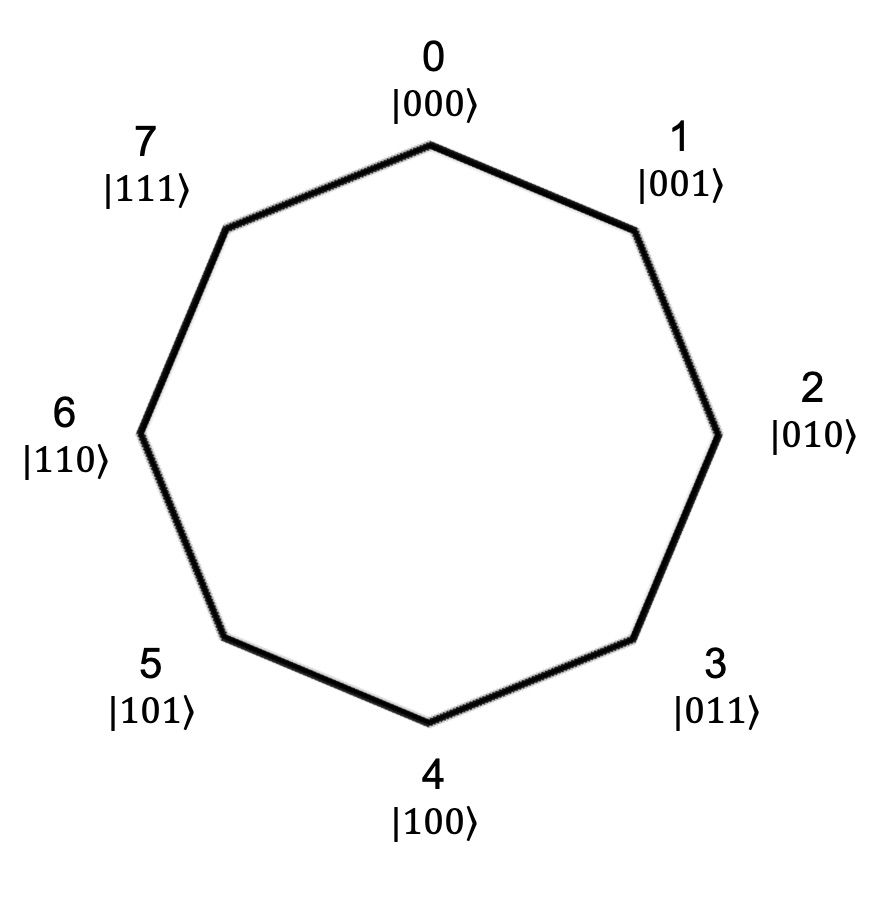

In [13]:
import os
import os.path
from IPython.display import display
from PIL import Image
path = "./8_white.jpg"
display(Image.open(path))

The operations propagate systemically around the graph as each node is a seperate bit-string value in lexicographic order. 

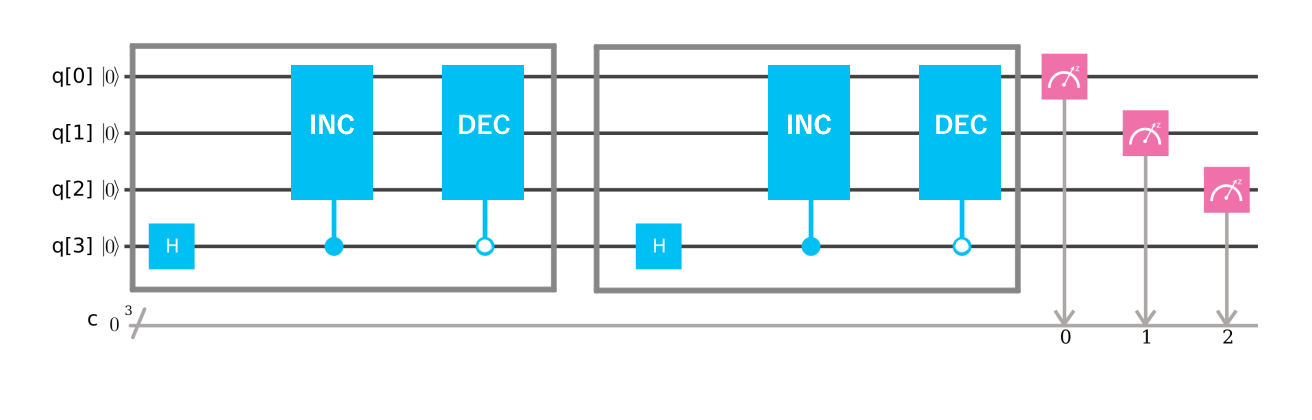

In [15]:
import os
import os.path
from IPython.display import display
from PIL import Image
path = "./whole_circuit.jpg"
display(Image.open(path))

In this style, programmer can insert initial position of walker as 3-qubits state. For example, if the input equals to 110, the position is 6.

In [1]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, BasicAer
from qiskit import execute
from qiskit.tools.visualization import plot_histogram,plot_state_city


from qiskit import IBMQ


n=3

In [2]:
#IN/DECREMENT GATES FOR N=3

def increment_gate(qwc, q, subnode):
  
  cnx(qwc, subnode[0], q[2], q[1], q[0])
  cnx(qwc, subnode[0], q[2], q[1])
  cnx(qwc, subnode[0], q[2])
    
  qwc.barrier()
  return qwc

def decrement_gate(qwc, q, subnode):
  
  qwc.x(subnode[0])
  qwc.x(q[2])
  qwc.x(q[1])
  cnx(qwc, subnode[0], q[2], q[1], q[0])
  qwc.x(q[1])
  cnx(qwc, subnode[0], q[2], q[1])
  qwc.x(q[2])
  cnx(qwc, subnode[0], q[2])
  qwc.x(subnode[0])

  return qwc
  
def stateVectorGenerator(circ):
  # Select the StatevectorSimulator from the Aer provider
  #localBE = BasicAer.get_backend('statevector_simulator')
  # Execute and get counts
  return execute(circ,ibmqBE).result().get_statevector(circ)
  
  
    
def ibmsim(circ):
  ibmqBE = IBMQ.get_backend('ibmq_qasm_simulator')
  return execute(circ,ibmqBE, shots=1000).result().get_counts(circ)  
def cnx(qc,*qubits):
    if len(qubits) >= 3:
        last = qubits[-1]
        #A matrix: (made up of a  and Y rotation, lemma4.3)
        qc.crz(np.pi/2, qubits[-2], qubits[-1])
        #cry
        qc.cu3(np.pi/2, 0, 0, qubits[-2],qubits[-1])
        
        #Control not gate
        cnx(qc,*qubits[:-2],qubits[-1])
        
        #B matrix (cry again, but opposite angle)
        qc.cu3(-np.pi/2, 0, 0, qubits[-2], qubits[-1])
        
        #Control
        cnx(qc,*qubits[:-2],qubits[-1])
        
        #C matrix (final rotation)
        qc.crz(-np.pi/2,qubits[-2],qubits[-1])
    elif len(qubits)==3:
        qc.ccx(*qubits)
    elif len(qubits)==2:
        qc.cx(*qubits)

In [3]:
def runQWC(qwc, times):
    for i in range(times):
        qwc.h(qsubnodes[0])
        increment_gate(qwc, qnodes, qsubnodes[0])
        decrement_gate(qwc,qnodes,qsubnodes[0])
        qwc.measure(qnodes, cnodes)

    return qwc

In [21]:
qnodes = QuantumRegister(n,'qc')
qsubnodes = QuantumRegister(1,'qanc')
csubnodes = ClassicalRegister(1,'canc')
cnodes = ClassicalRegister(n,'cr')

qwc = QuantumCircuit(qnodes, qsubnodes, cnodes, csubnodes)


qwc = runQWC(qwc, 15)
result = ibmsim(qwc)
print(result)

# qwc.draw(output='mpl')


{'0 100': 230, '0 111': 248, '0 101': 254, '0 110': 268}


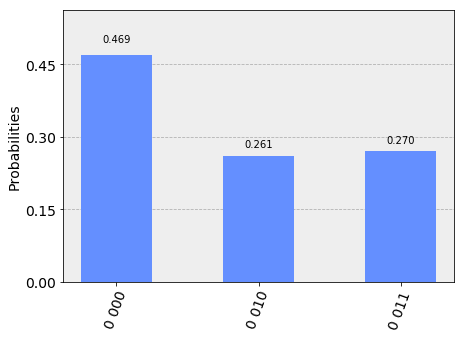

In [43]:
result = ibmsim(qwc)
#plot_state_city(result, title="result")
plot_histogram(result)

In [ ]:
result = ibmsim(qwc)
#plot_state_city(result, title="result")
plot_histogram(result)

In [ ]:
print(result)

In [5]:
result = ibmsim(qwc)
#plot_state_city(result, title="result")
plot_histogram(result)

QiskitBackendNotFoundError: 'No backend matches the criteria'

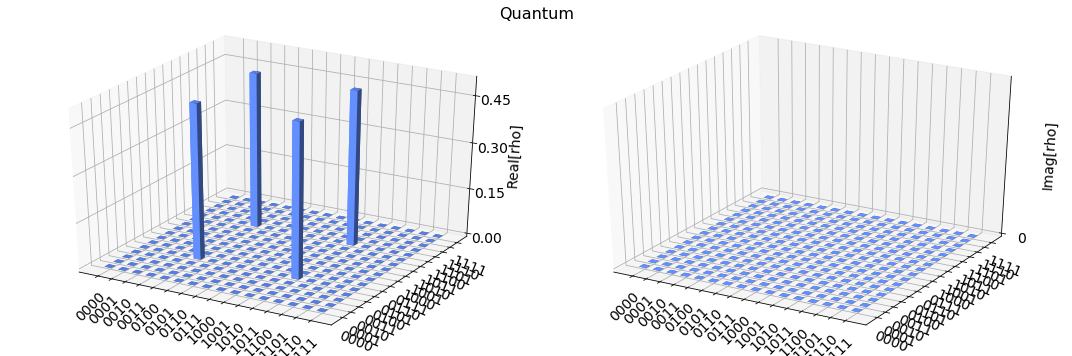

In [5]:
sv = stateVectorGenerator(qwc)
plot_state_city(sv, title='Quantum')

In [12]:
qwc.measure(qnodes, cnodes)
sv = stateVectorGenerator(qwc)
print(sv)
plot_state_city(sv, title='state post-measurement')


NameError: name 'ibmqBE' is not defined

n-qubit toffoli

In [7]:
IBMQ.active_accounts()

[]

In [ ]:
IBMQ.stored_accounts()


In [4]:
IBMQ.enable_account("53a94ea70a24c85cfac5f5e87e369d813f5efff70fed9c973b2b3637be5b2e0378da1921b5bbd786574e74d44dd8a64dda3095dbbda528b414c1b567476a87b2")

In [5]:
IBMQ.backends()

[<IBMQBackend('ibmqx4') from IBMQ()>,
 <IBMQBackend('ibmqx2') from IBMQ()>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ()>,
 <IBMQBackend('ibmq_qasm_simulator') from IBMQ()>]

In [ ]:
#53a94ea70a24c85cfac5f5e87e369d813f5efff70fed9c973b2b3637be5b2e0378da1921b5bbd786574e74d44dd8a64dda3095dbbda528b414c1b567476a87b2